# Logistic regression for a multi-class problem

In this notebook, we are going to perform a logistic regression (cf. previous session slides and notebooks) on a classification problem where our classes are not just `positive` and `negative` (`pass` and `fail` in the previous notebook), but a larger range of possibilities. We are going to create a classifier identifying the dominant species of tree in a 30×30 meters patch of forest, among 7 total possible tree covers. To do so, we will rely on a much larger number of possible features than during previous classes.

## Load libraries and data

In [ ]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_covtype
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

In [ ]:
dataset= fetch_covtype(data_home=os.getcwd() + "/cache/")
df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
df["Cover_Type"] = dataset.target
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,Wilderness_Area_1,Wilderness_Area_2,Wilderness_Area_3,Soil_Type_0,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


## Data exploration

### Base statistics

In [9]:
df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,Wilderness_Area_1,Wilderness_Area_2,Wilderness_Area_3,Soil_Type_0,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,0.448865,0.051434,0.436074,0.063627,0.005217,0.012952,0.008301,0.021335,0.002749,0.011316,0.000181,0.000308,0.001974,0.056168,0.021359,0.051584,0.030001,0.001031,0.000005,0.004897,0.005890,0.003268,0.006921,0.015936,0.001442,0.057439,0.099399,0.036622,0.000816,0.004456,0.001869,0.001628,0.198356,0.051927,0.044175,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,0.497379,0.220882,0.495897,0.244087,0.072039,0.113066,0.090731,0.144499,0.052356,0.105775,0.013442,0.017550,0.044387,0.230245,0.144579,0.221186,0.170590,0.032092,0.002272,0.069804,0.076518,0.057077,0.082902,0.125228,0.037950,0.232681,0.299197,0.187833,0.028551,0.066605,0.043193,0.040318,0.398762,0.221879,0.205483,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [12]:
print("Class distribution:\n", df['Cover_Type'].value_counts())

Class distribution:
 Cover_Type
2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: count, dtype: int64


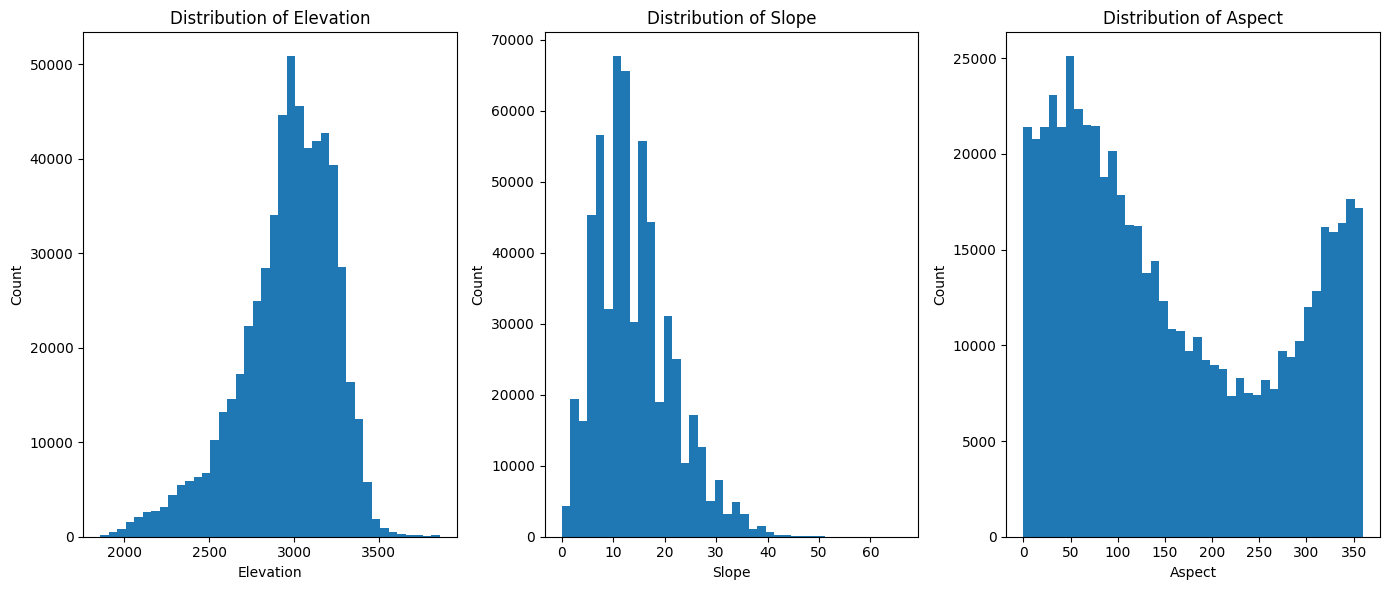

In [22]:
fig, axes = plt.subplots(ncols=3, figsize=(14, 6))
for col, ax in zip(['Elevation','Slope','Aspect'], axes):
    ax.hist(df[col], bins=40)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

fig.tight_layout()

### Correlation matrix between continuous features

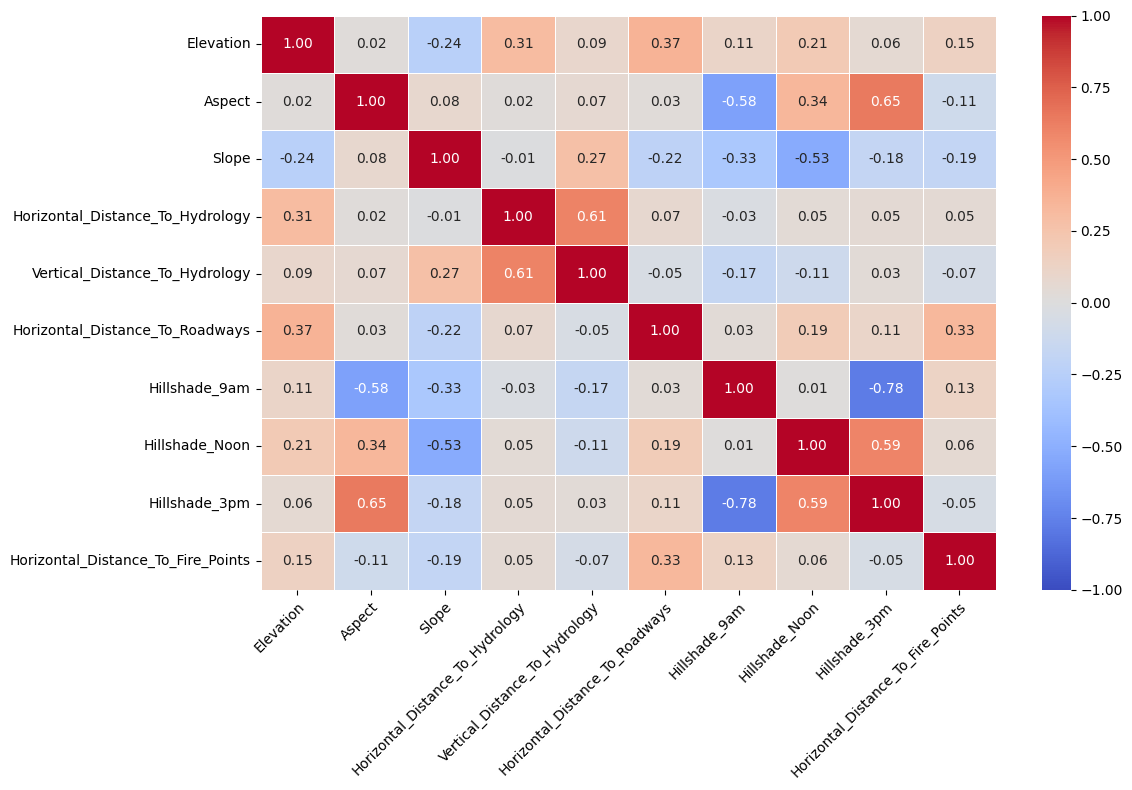

In [18]:
continuous_features = df.columns[:10].tolist()
corr_matrix = df[continuous_features].corr()

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode='anchor')
fig.tight_layout()

## Feature engineering

Here, we are going to create three additional features for our dataset: one computing the total hillshade of the patch, another one computing the Euclidian distance to the hydrology point, and a last one computing the interaction effect of distance to roadways and fire points.

In [25]:
df['Hillshade_Total'] = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].sum(axis='columns')

df['Euclid_Distance_To_Hydrology'] = np.sqrt(
    df['Horizontal_Distance_To_Hydrology']**2 + df['Vertical_Distance_To_Hydrology']**2
)

df['Road_Fire_Interaction'] = df['Horizontal_Distance_To_Roadways'] * df['Horizontal_Distance_To_Fire_Points']

## Model training

Now that our dataset is ready, we are going to train our multi-class logistic regression model.

In [26]:
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)


In [37]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(n_jobs=-1, max_iter=1000, penalty="l2", random_state=1234))
])

model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(max_iter=5000, n_jobs=-1,
                                    random_state=1234))])

In [48]:
coef_df = pd.DataFrame(model["logreg"].coef_, columns=X.columns, index=[f"Class {c}" for c in model["logreg"].classes_])

# Display top 10 predictors per class
for cls in coef_df.index:
    print(f"Top predictors for {cls}:")
    print(coef_df.loc[cls].abs().sort_values(ascending=False).head(3))
    print("\n")


Top predictors for Class 1:
Elevation            3.295046
Wilderness_Area_3    1.560647
Wilderness_Area_0    1.013751
Name: Class 1, dtype: float64


Top predictors for Class 2:
Elevation            0.942765
Soil_Type_11         0.796161
Wilderness_Area_2    0.757749
Name: Class 2, dtype: float64


Top predictors for Class 3:
Elevation                3.583685
Hillshade_Noon           1.159286
Road_Fire_Interaction    0.880128
Name: Class 3, dtype: float64


Top predictors for Class 4:
Elevation                          5.148437
Horizontal_Distance_To_Roadways    2.824013
Wilderness_Area_3                  2.062728
Name: Class 4, dtype: float64


Top predictors for Class 5:
Wilderness_Area_3    1.673807
Soil_Type_21         1.203045
Wilderness_Area_0    1.161027
Name: Class 5, dtype: float64


Top predictors for Class 6:
Elevation         3.366270
Hillshade_Noon    2.840329
Hillshade_3pm     2.175642
Name: Class 6, dtype: float64


Top predictors for Class 7:
Elevation                  

## Model evaluation

In [42]:
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           1       0.72      0.70      0.71     42368
           2       0.75      0.80      0.77     56661
           3       0.68      0.80      0.73      7151
           4       0.62      0.41      0.50       549
           5       0.26      0.01      0.01      1899
           6       0.49      0.28      0.35      3473
           7       0.79      0.62      0.70      4102

    accuracy                           0.73    116203
   macro avg       0.61      0.52      0.54    116203
weighted avg       0.72      0.73      0.72    116203



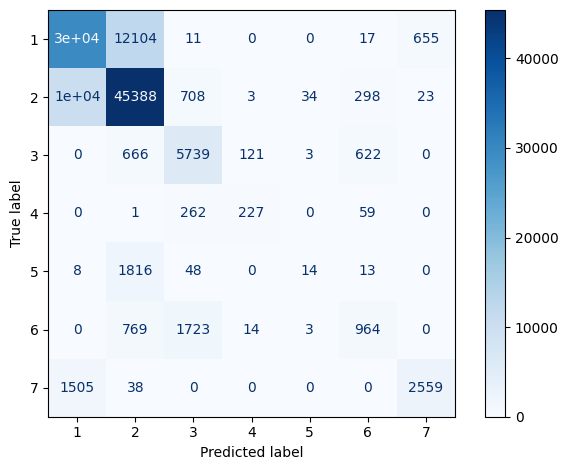

In [41]:
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    cmap=plt.cm.Blues
)
plt.tight_layout()

As you can see, our model performs really well for classes with a lot ef examples (1 and 2) but has trouble generalizing to the less common classes. The model design itself can also be questioned and a good strategy if we wanted to improve performances would be to try other types of models (e.g., Random Forest, Gradient Boosting) and choose the one giving the best performances.